In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated,List
from langgraph.graph import add_messages, StateGraph, END
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from pydantic import BaseModel

In [29]:
load_dotenv()

True

In [30]:
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]

In [31]:
search_tool=TavilySearchResults(max_results=5)

In [32]:
tools=[search_tool]

In [33]:
llmGemini=ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

In [34]:
llm_with_tools=llmGemini.bind_tools(tools=tools)

In [35]:
def model(state: AgentState):
    state["messages"]=[llm_with_tools.invoke(input=state["messages"])]
    return state
    

In [36]:
def tools_router(state:AgentState):
    last_message=state["messages"][-1]

    if hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0:
        return "tool_node"
    else:
        return "end"

In [37]:
tool_node=ToolNode(tools=tools,messages_key="messages")

In [38]:
graph=StateGraph(state_schema=AgentState)

In [39]:
graph.add_node(node="model",action=model)

In [40]:
graph.add_node(node="tool_node",action=tool_node)

In [41]:
graph.set_entry_point(key="model")

In [42]:
graph.add_conditional_edges(source="model",path=tools_router,path_map={"tool_node":"tool_node","end":END})

In [43]:
graph.add_edge(start_key="tool_node",end_key="model")

In [44]:
app=graph.compile()

In [45]:
print(app.get_graph().draw_ascii())

          +-----------+           
          | __start__ |           
          +-----------+           
                 *                
                 *                
                 *                
            +-------+             
            | model |             
            +-------+.            
           **         ..          
         **             ..        
        *                 .       
+-----------+         +---------+ 
| tool_node |         | __end__ | 
+-----------+         +---------+ 


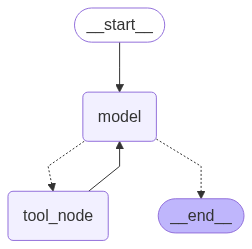

In [46]:
display(Image(data=app.get_graph(xray=True).draw_mermaid_png()))

In [47]:
input={
    "messages":["What's the current weather in Bangalore?"]
}

In [48]:
app.invoke(input=input)

{'messages': [HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='669bab31-384d-4e75-ae35-74badd5dc0e6'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Bangalore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--6f704ca0-0821-44f1-ba19-bdca5a9e70dd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bangalore'}, 'id': '339ec329-d921-49b3-8600-9f270e8c649e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 12, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"title": "Weather in Bengaluru in July 2025 - Detailed Forecast", "url": "https://www.easeweather.com/asia/india/karnataka/bangalore-urban/bengaluru/july", 

In [49]:
events=app.stream(input=input, stream_mode="values")

In [50]:
for event in events:
    print(event,"\n")

{'messages': [HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='52c66ad2-a7ce-4d0e-b0f8-fcada8e6bc07')]} 

{'messages': [HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='52c66ad2-a7ce-4d0e-b0f8-fcada8e6bc07'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Bangalore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--84c611e3-5719-42d3-b003-e04e3f76b876-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bangalore'}, 'id': 'a69f51e7-4b49-4d4e-9d6f-a2450b155b1a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 12, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}})]} 

{'messages

In [51]:
events=app.stream(input=input, stream_mode="updates")

In [52]:
for event in events:
    print(event,"\n")

{'model': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather in Bangalore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--34247da5-44c0-49f4-8268-61c3b4e1b093-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Bangalore'}, 'id': '72931b96-dd66-4238-aaff-33b30fbfe3d9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 12, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}})]}} 

{'tool_node': {'messages': [ToolMessage(content='[{"title": "Weather in Bengaluru in July 2025 - Detailed Forecast", "url": "https://www.easeweather.com/asia/india/karnataka/bangalore-urban/bengaluru/july", "content": "So far, July 2025 in Bengaluru is slightly warmer than the historical average by 0.9°C.\\n\\n   Expect 

In [68]:
input={
    "messages":["Which WWE Superstar passed away recently?"]
}

In [69]:
events=app.astream_events(input=input, version="v2")

In [70]:
async for event in events:
    print(event,"\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Which WWE Superstar passed away recently?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'c770539a-54dc-4cbd-a4f4-293fd475433f', 'metadata': {}, 'parent_ids': []} 

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Which WWE Superstar passed away recently?', additional_kwargs={}, response_metadata={}, id='e63e35b2-40ec-4708-8682-f79d5707d68c')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '4df9e851-51dd-44fc-b5e3-eab562fcaab8', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:c14f2cd8-1306-533d-ab1f-071b85c9a069'}, 'parent_ids': ['c770539a-54dc-4cbd-a4f4-293fd475433f']} 

{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Which WWE Superstar passed away recently?', additional_kwargs={}, response_metadata={}, id='

In [71]:
events=app.astream_events(input=input, version="v2")

In [72]:
async for event in events:
    if event["event"]=="on_chat_model_stream":
        print(event['data']['chunk'].content,end="",flush=True)

Based on the search results, it appears that Hulk Hogan passed away on Thursday, July 24, 2025, at the age of 71. However, please note that this information is based on search results from 2025 and may not be accurate.

Wrestlers who have recently passed away in 2023 and 2024 include:

*   Ice Train / MI Smooth (January 23, 2024)
*   Killer Khan (December 29, 2023)
*   Osamu Kido (December 11, 2023)
*   Adnan Al-Kaissie (September 6, 2023)
*   Bray Wyatt (August 24, 2023)
*   Terry Funk (August 23, 2023)
*   Darren Drozdov (June 30, 2023)
*   The Iron Sheik (June 7, 2023)